In [2]:
import astroplan
import regions
from astropy.coordinates import ICRS, SkyCoord, AltAz, get_moon, EarthLocation, get_body
from astropy import units as u
from astropy.utils.data import download_file
from astropy.table import Table, QTable, join
from astropy.time import Time, TimeDelta
from astropy_healpix import *
from ligo.skymap import plot
from ligo.skymap.io import read_sky_map
import healpy as hp
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import datetime as dt
import pickle
import pandas as pd
from docplex.mp.model import Model
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.simplefilter('ignore', astroplan.TargetNeverUpWarning)
warnings.simplefilter('ignore', astroplan.TargetAlwaysUpWarning)

## Preprocessing

In [4]:
directory_path = "/u/ywagh/test_skymaps/"
filelist = sorted([f for f in os.listdir(directory_path) if f.endswith('.gz')])

slew_speed = 2.5 * u.deg / u.s
slew_accel = 0.4 * u.deg / u.s**2
readout = 8.2 * u.s

ns_nchips = 4
ew_nchips = 4
ns_npix = 6144
ew_npix = 6160
plate_scale = 1.01 * u.arcsec
ns_chip_gap = 0.205 * u.deg
ew_chip_gap = 0.140 * u.deg

ns_total = ns_nchips * ns_npix * plate_scale + (ns_nchips - 1) * ns_chip_gap
ew_total = ew_nchips * ew_npix * plate_scale + (ew_nchips - 1) * ew_chip_gap

rcid = np.arange(64)

chipid, rc_in_chip_id = np.divmod(rcid, 4)
ns_chip_index, ew_chip_index = np.divmod(chipid, ew_nchips)
ns_rc_in_chip_index = np.where(rc_in_chip_id <= 1, 1, 0)
ew_rc_in_chip_index = np.where((rc_in_chip_id == 0) | (rc_in_chip_id == 3), 0, 1)

ew_offsets = ew_chip_gap * (ew_chip_index - (ew_nchips - 1) / 2) + ew_npix * plate_scale * (ew_chip_index - ew_nchips / 2) + 0.5 * ew_rc_in_chip_index * plate_scale * ew_npix
ns_offsets = ns_chip_gap * (ns_chip_index - (ns_nchips - 1) / 2) + ns_npix * plate_scale * (ns_chip_index - ns_nchips / 2) + 0.5 * ns_rc_in_chip_index * plate_scale * ns_npix

ew_ccd_corners = 0.5 * plate_scale * np.asarray([ew_npix, 0, 0, ew_npix])
ns_ccd_corners = 0.5 * plate_scale * np.asarray([ns_npix, ns_npix, 0, 0])

ew_vertices = ew_offsets[:, np.newaxis] + ew_ccd_corners[np.newaxis, :]
ns_vertices = ns_offsets[:, np.newaxis] + ns_ccd_corners[np.newaxis, :]

def get_footprint(center):
    return SkyCoord(
        ew_vertices, ns_vertices,
        frame=center[..., np.newaxis, np.newaxis].skyoffset_frame()
    ).icrs

url = 'https://github.com/ZwickyTransientFacility/ztf_information/raw/master/field_grid/ZTF_Fields.txt'
filename = download_file(url)
field_grid = QTable(np.recfromtxt(filename, comments='%', usecols=range(3), names=['field_id', 'ra', 'dec']))
field_grid['coord'] = SkyCoord(field_grid.columns.pop('ra') * u.deg, field_grid.columns.pop('dec') * u.deg)
field_grid = field_grid[0:881]

#******************************************************************************
# skymap, metadata = read_sky_map(os.path.join(directory_path, filelist[40]))
# skymap, metadata = read_sky_map(os.path.join("/u/ywagh/BNS.fits"))
skymap, metadata = read_sky_map(os.path.join("/u/ywagh/thousand_skymaps/skymaps/skymaps/S230630ab_bayestar.multiorder.fits"))
# plot_filename = os.path.basename(filelist[40])
# print(plot_filename)
# plot_filename = 'S240422ed'
# ci
#******************************************************************************

event_time = Time(metadata['gps_time'], format='gps').utc
gps_time = Time(metadata['gps_time'], format='gps')

event_time.format = 'iso'
print('event time:',event_time)
observer = astroplan.Observer.at_site('Palomar')
night_horizon = -18 * u.deg
if observer.is_night(event_time, horizon=night_horizon):
    start_time = event_time
else:
    start_time = observer.sun_set_time(
        event_time, horizon=night_horizon, which='next')

# Find the latest possible end time of observations: the time of sunrise.
# end_time = observer.sun_rise_time(
#     start_time, horizon=night_horizon, which='next')

'''
For comparison with GWEMOPT
'''
end_time = start_time + 12*u.hour

min_airmass = 2.5 * u.dimensionless_unscaled
airmass_horizon = (90 * u.deg - np.arccos(1 / min_airmass))
targets = field_grid['coord']

# Find the time that each field rises and sets above an airmass of 2.5.
target_start_time = Time(np.where(
    observer.target_is_up(start_time, targets, horizon=airmass_horizon),
    start_time,
    observer.target_rise_time(start_time, targets, which='next', horizon=airmass_horizon)))
target_start_time.format = 'iso'

# Find the time that each field sets below the airmass limit. If the target
# is always up (i.e., it's circumpolar) or if it sets after surnsise,
# then set the end time to sunrise.


target_end_time = observer.target_set_time(
    target_start_time, targets, which='next', horizon=airmass_horizon)
target_end_time[
    (target_end_time.mask & ~target_start_time.mask) | (target_end_time > end_time)
] = end_time
target_end_time.format = 'iso'
# Select fields that are observable for long enough for at least one exposure
##############################################################################
exposure_time = 30 * u.second
exposure_time_day = exposure_time.to_value(u.day)

num_visits = 3
num_filters = 1

cadence = 30         #minutes
cadence_days = cadence / (60 * 24)
##############################################################################
field_grid['start_time'] = target_start_time
field_grid['end_time'] = target_end_time
observable_fields = field_grid[target_end_time - target_start_time >= exposure_time]

# print(observable_fields)
hpx = HEALPix(nside=256, frame=ICRS())

footprint = np.moveaxis(
    get_footprint(SkyCoord(0 * u.deg, 0 * u.deg)).cartesian.xyz.value, 0, -1)
footprint_healpix = np.unique(np.concatenate(
    [hp.query_polygon(hpx.nside, v, nest=(hpx.order == 'nested')) for v in footprint]))

'''
# computing the footprints of every ZTF field as HEALPix indices. Downsampling skymap to same resolution.
'''
footprints = np.moveaxis(get_footprint(observable_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints)]

prob = hp.ud_grade(skymap, hpx.nside, power=-2)

# k = max number of 300s exposures 
min_start = min(observable_fields['start_time'])
max_end =max(observable_fields['end_time'])
# min_start.format = 'jd'
# max_end.format = 'jd'

# k=15

slew_time_avg = 20*u.second
slew_time_day_avg = slew_time_avg.to(u.day)
k = int(np.floor((max_end - min_start)/(num_visits*num_filters*((exposure_time.to(u.day)+slew_time_day_avg)))))

# k = int(np.floor((max_end - min_start)/(1*exposure_time.to(u.day))))
# k = np.floor(k/(num_visits*num_filters))
print(k," number of exposures could be taken tonight")

print("problem setup completed")

event time: 2023-06-30 09:46:27.204


/u/ywagh/.local/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  0%|          | 0/593 [00:00<?, ?it/s]

288  number of exposures could be taken tonight
problem setup completed


## Model 1 - Coverage probelm

In [19]:
m1 = Model('max coverage problem')

field_vars = m1.binary_var_list(len(footprints), name='field')
pixel_vars = m1.binary_var_list(hpx.npix, name='pixel')

footprints_healpix_inverse = [[] for _ in range(hpx.npix)]

for field, pixels in enumerate(footprints_healpix):
    for pixel in pixels:
        footprints_healpix_inverse[pixel].append(field)

for i_pixel, i_fields in enumerate(footprints_healpix_inverse):
    m1.add_constraint(m1.sum(field_vars[i] for i in i_fields) >= pixel_vars[i_pixel])

m1.add_constraint(m1.sum(field_vars) <= k)
m1.maximize(m1.dot(pixel_vars, prob))
print(f"number fo fields observed should be less than {k}")

solution = m1.solve(log_output=True)
print("optimization completed")
total_prob_covered = solution.objective_value

print("Total probability covered:",total_prob_covered)

selected_fields_ID = [i for i, v in enumerate(field_vars) if v.solution_value == 1]
print(len(selected_fields_ID), "fields selected")
selected_fields_all = observable_fields[selected_fields_ID]
# print(selected_fields)

separation_matrix = selected_fields_all['coord'][:,np.newaxis].separation(selected_fields_all['coord'][np.newaxis,:])

def slew_time(separation):
   return np.where(separation <= (slew_speed**2 / slew_accel),
                   np.sqrt(2 * separation / slew_accel),
                   (2 * slew_speed / slew_accel) + (separation - slew_speed**2 / slew_accel) / slew_speed)

slew_times = slew_time(separation_matrix).value

slew_time_value = slew_times*u.second
slew_time_day = slew_time_value.to_value(u.day)

footprints_selected = np.moveaxis(get_footprint(selected_fields_all['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fields_all['probabilities'] = probabilities
print("number of fields are:", len(selected_fields_all))
# print("the sum of prob for all the fields covering the loc is:", np.sum(selected_fields_all["probabilities"]))

number fo fields observed should be less than 288
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.02 sec. (24.20 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 783493 rows and 400737 columns.
Aggregator did 531 substitutions.
Reduced MIP has 2409 rows, 2940 columns, and 8871 nonzeros.
Reduced MIP has 2940 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.90 sec. (801.18 ticks)
Probing time = 0.00 sec. (0.60 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2409 rows, 2940 columns, and 8871 nonzeros.
Reduced MIP has 2940 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.54 ticks)
Probing time = 0.00 sec. (0.60 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.01 sec. (3.94 ticks)

       

  0%|          | 0/288 [00:00<?, ?it/s]

worked for 288 fields
number of fields are: 288


In [6]:
mask = selected_fields_all["probabilities"]>1e-3
selected_fields = selected_fields_all[mask]
# selected_fields = selected_fields_all
print("the sum of prob for all the fields covering the loc and after filtering acc to prob is:", np.sum(selected_fields["probabilities"]))
print("number of fields are:", len(selected_fields))

the sum of prob for all the fields covering the loc and after filtering acc to prob is: 0.7539990496166041
number of fields are: 131


In [ ]:
# plt.figure(figsize=(6, 6), dpi = 100)
# ax = plt.axes(projection='geo globe', center='22h 30d')
# ax.imshow_hpx(prob, cmap='cylon')
# ax.grid()

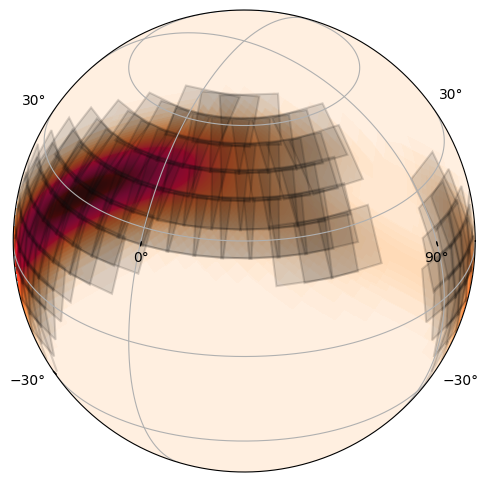

In [7]:
plt.figure(figsize=(6, 6), dpi = 100)
#off-center case
# ax = plt.axes(projection='astro mollweide', center='0h 60d')
ax = plt.axes(projection='geo globe', center='2h 30d')

for row in selected_fields:
    coords = SkyCoord(
        [ew_total, -ew_total, -ew_total, ew_total],
        [ns_total, ns_total, -ns_total, -ns_total],
        frame=row['coord'].skyoffset_frame()
    ).icrs
    ax.add_patch(plt.Polygon(
    np.column_stack((coords.ra.deg, coords.dec.deg)),
    facecolor=(0.1, 0.1, 0.1),  # Light gray fill
    edgecolor='black',      # Dark black edge
    linewidth=1.5,          # Increase edge thickness for contrast
    alpha=0.15,              # Apply transparency to facecolor only
    transform=ax.get_transform('world')
))

# plot_filename = os.path.basename(skymap_file)
plot_filename = 'S240910ci'
ax.grid()
ax.imshow_hpx(prob, cmap='cylon')
# plt.text(0.05, 0.95, f'Total Probability Covered: {total_prob_covered:.2f}', transform=ax.transAxes,
#         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

In [ ]:
# array = np.array(selected_fields["probabilities"])
# plt.plot(np.sort(array))

In [ ]:
for i, field in enumerate(selected_fields):
    visits = [solution.get_value(x[i][v]) for v in range(num_visits)]
    print(f"Field {field['field_id']}: Visits {visits}")

In [18]:
def calculate_total_prob_and_area(selected_field_ids, field_grid, footprints_healpix, prob, nside=256):
    """Calculate total probability and sky coverage for selected fields.
    
    Args:
        selected_field_ids: List of field_ids to include (e.g., [294, 295, 296])
        field_grid: The complete QTable containing all fields (observable_fields)
        footprints_healpix: Precomputed list of HEALPix indices for all fields
        prob: Skymap probability array
        nside: HEALPix resolution
    
    Returns:
        Total probability and area in square degrees
    """
    # Convert field_ids to indices in the original table
    selected_indices = [np.where(field_grid['field_id'] == field_id)[0][0] 
                       for field_id in selected_field_ids]
    
    # Aggregate pixels from selected fields
    all_pixels = np.concatenate([footprints_healpix[i] for i in selected_indices])
    unique_pixels = np.unique(all_pixels)
    
    total_prob = np.sum(prob[unique_pixels])
    total_area = len(unique_pixels) * hp.nside2pixarea(nside, degrees=True)
    
    return total_prob, total_area

In [30]:
# delta = exposure_time.to_value(u.day)

# limit_duration = ((end_time-start_time).value*2/3) 
# filtered_rows = [
#     row for row in selected_fields
#     if (row['end_time'] - row['start_time']).to_value(u.day) > limit_duration
# ]

# # Create a new QTable with the filtered rows
# selected_fields = QTable(rows=filtered_rows, names=selected_fields.colnames)

# selected_fields

In [ ]:
# # Verify time windows for each field
# for i, row in enumerate(selected_fields):
#     print(f"Field {i}:")
#     print(f"Start time: {row['start_time']}")
#     print(f"End time: {row['end_time']}")
#     print(f"Window duration: {row['end_time'] - row['start_time']}")
#     delta = exposure_time.to_value(u.day)

#     if (row['end_time'] - row['start_time']).to_value(u.day) < (num_visits * num_filters * delta):
#         print(f"Warning: Time window might be too short for field {i}")

## Model 2 - Scheduling Problem

In [9]:
m2 = Model("Telescope timings")

cadence = 30         #minutes
cadence_days = cadence / (60 * 24)
num_revisits = num_visits*num_filters
delta = exposure_time.to_value(u.day)
M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()
# Convert 12 hours to days explicitly
gamma = 12*u.hour
observation_window_days = gamma.to(u.day).value

x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
      for v in range(num_visits*num_filters)] 
      for i in range(len(selected_fields))]

tc = [[m2.continuous_var(
    lb=0,
    ub=observation_window_days - exposure_time_day,
    name=f"start_time_field_{i}_visit_{v}")
    for v in range(num_visits*num_filters)] 
    for i in range(len(selected_fields))]

# tc = [[m2.continuous_var(
#     lb=(row['start_time'] - start_time).to_value(u.day),
#     ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
#     name=f"start_time_field_{i}_visit_{v}")
#     for v in range(num_visits*num_filters)] 
#     for i, row in enumerate(selected_fields)]

visit_transition_times = [m2.continuous_var(
    lb=0,ub=M,name=f"visit_transition_{v}")
                          for v in range(num_visits*num_filters-1)]  

# Isolating visits
for v in range(1, num_visits*num_filters):
    for i in range(len(selected_fields)):
        m2.add_constraint(tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
            ctname=f"visit_end_{i}_visit_{v-1}")
        m2.add_constraint(tc[i][v] >= visit_transition_times[v-1],
            ctname=f"visit_start_{i}_visit_{v}")

for v in range(1, num_visits*num_filters):
    for i in range(len(selected_fields)):
        m2.add_constraint(tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
            ctname=f"visit_end_{i}_visit_{v-1}")
        m2.add_constraint(tc[i][v] >= visit_transition_times[v-1],
            ctname=f"visit_start_{i}_visit_{v}")

# Cadence constraints
for i in range(len(selected_fields)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= (cadence_days+delta) * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")


#non-overlapping
for v in range(num_visits*num_filters):
    for i in range(len(selected_fields)):
        for j in range(i):
            m2.add_constraint(tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")

# Initialize the objective
# m2.maximize(m2.sum(probabilities[i] * x[i][v]
#            for i in range(len(selected_fields))
#            for v in range(num_visits*num_filters)))

# To get unique probability coverage, you could use:
unique_field_vars = m2.binary_var_list(len(selected_fields), name='unique_field')
for i in range(len(selected_fields)):
    m2.add_constraint(unique_field_vars[i] <= m2.sum(x[i][v] for v in range(num_revisits)))
m2.maximize(m2.sum(probabilities[i] * m2.logical_or(*[x[i][v] for v in range(num_revisits)]) 
              for i in range(len(selected_fields))))

# m2.parameters.timelimit = 60
# m2.parameters.mip.tolerances.mipgap = 0.01  # 1% optimality gap
m2.parameters.emphasis.mip = 2  # Emphasize optimality over feasibility
m2.parameters.mip.strategy.variableselect = 4
solution = m2.solve(log_output=True)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_MIP_Strategy_VariableSelect             4
CPXPARAM_Emphasis_MIP                            2
Tried aggregator 1 time.
MIP Presolve eliminated 655 rows and 131 columns.
MIP Presolve modified 69246 coefficients.
Reduced MIP has 52400 rows, 919 columns, and 208028 nonzeros.
Reduced MIP has 524 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.10 sec. (123.64 ticks)
Probing fixed 516 vars, tightened 136831 bounds.
Probing changed sense of 346 constraints.
Probing time = 7.29 sec. (7998.72 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 25284 rows and 516 columns.
MIP Presolve modified 2592 coefficients.
Reduced MIP has 27116 rows, 403 columns, and 55808 nonzeros.
Reduced MIP has 8 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (41.70 ticks)
Probing fixed 0 vars, tightened 528 bounds.
Probing time = 0.01 sec. (11.10 ticks)
Tried

In [9]:
solution

docplex.mp.solution.SolveSolution(obj=0.953593,values={x_0_visit_0:1,x_0..

In [10]:
solution.solve_status

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [22]:
# for v in range(num_visits * num_filters):
#     visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
#     print(visit_fields)

In [11]:
solution.objective_value

0.23953688526793765

In [58]:
observed_fields = [i for i in range(len(selected_fields)) 
                   if sum(solution.get_value(x[i][v]) for v in range(num_visits*num_filters)) > 0]
total_prob_covered = sum(probabilities[i] for i in observed_fields)
print("Total probability covered:", total_prob_covered)

Total probability covered: 0.0001625556080459572


In [12]:

scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fields.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fields)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(scheduled_fields))]

In [13]:
req = list(observable_fields["field_id"].value)
total_prob, total_area = calculate_total_prob_and_area(
    req,
    observable_fields,  
    footprints_healpix,
    prob,
    hpx.nside
)

print(f"#######################    Total probability covered: {total_prob:.6f}                #######################")
print(f"#######################    Total sky coverage area: {total_area:.2f} square degrees    #######################")

#######################    Total probability covered: 0.696068                #######################
#######################    Total sky coverage area: 24227.68 square degrees    #######################


In [14]:
len(scheduled_tc)

131

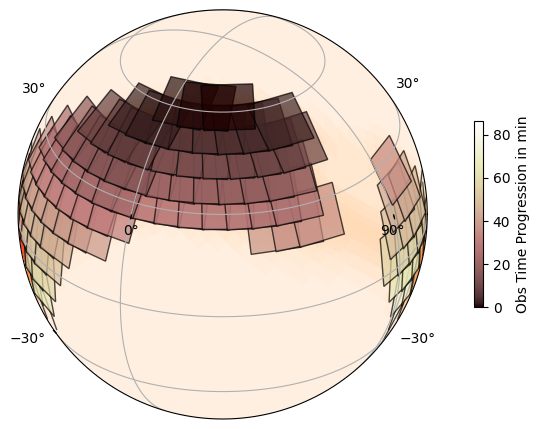

In [153]:
from fractions import Fraction
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.time import Time
from astropy.coordinates import SkyCoord

# Convert start times to numeric values
start_times = scheduled_tc[:, 0] * 24 *60 # Extract first column (start times)
min_time = min(start_times)
time_diffs = np.array(start_times) - min_time  # Time differences from the earliest tile

# Normalize to range [0, 1]
norm = mcolors.Normalize(vmin=min(time_diffs), vmax=max(time_diffs))
cmap = matplotlib.colormaps.get_cmap('pink')  # Use binary colormap

plt.figure(figsize=(6, 6), dpi = 100)
ax = plt.axes(projection='geo globe', center='2h 30d')

for row, time_diff in zip(selected_fields, time_diffs):
    coords = SkyCoord(
        [ew_total, -ew_total, -ew_total, ew_total],
        [ns_total, ns_total, -ns_total, -ns_total],
        frame=row['coord'].skyoffset_frame()
    ).icrs

    color = cmap(norm(time_diff))  # Get color based on time difference

    ax.add_patch(plt.Polygon(
        np.column_stack((coords.ra.deg, coords.dec.deg)),
        alpha=0.7,
        facecolor=color,
        edgecolor='black',
        transform=ax.get_transform('world')
    ))

ax.grid()
ax.imshow_hpx(prob, cmap='cylon')

# Add colorbar
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Obs Time Progression in min",fraction=0.02, pad=0.1)

plt.show()


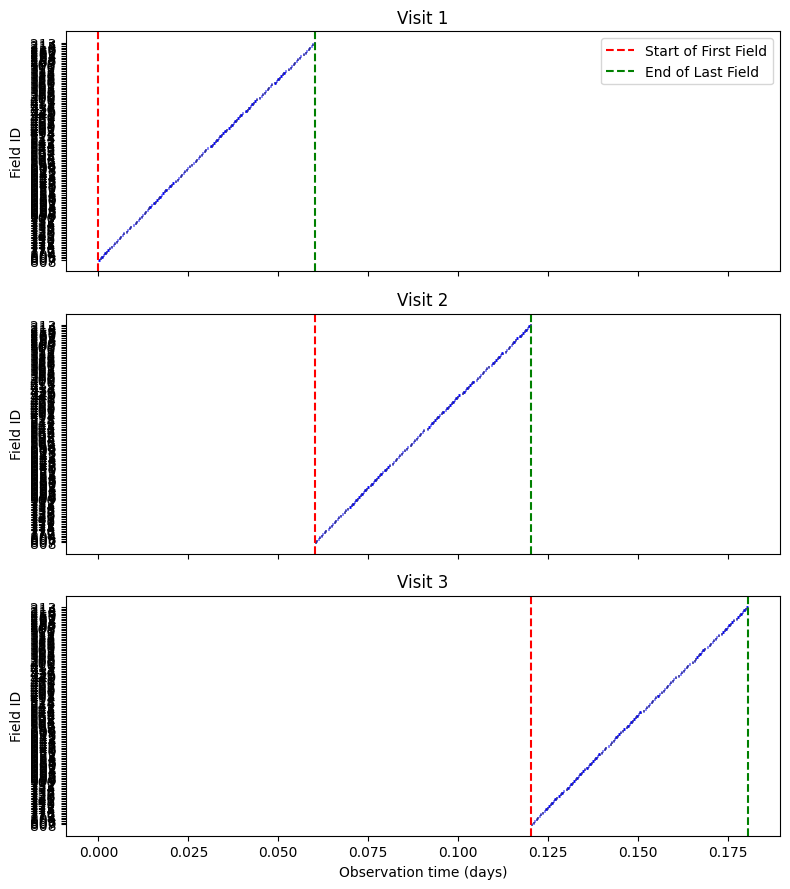

In [154]:
import warnings
from astropy import units as u
from erfa import ErfaWarning

# Suppress ERFA warnings if desired
warnings.filterwarnings('ignore', category=ErfaWarning)

n_visits = num_visits * num_filters  

fig, axes = plt.subplots(n_visits, 1, figsize=(8, 3 * n_visits), sharex=True)
if n_visits == 1:
    axes = [axes]

for i in range(n_visits):
    start_col = f'Scheduled_start_filt_times_{i}'
    end_col = f'Scheduled_end_filt_times_{i}'
    
    # Filter valid rows
    valid_rows = ~np.isnan(scheduled_tc).any(axis=1)
    valid_scheduled_tc = scheduled_tc[valid_rows]
    valid_scheduled_fields = scheduled_fields[valid_rows]
    
    if len(valid_scheduled_fields) == 0:
        print(f"No entries found for Visit {i + 1}. Skipping plot.")
        continue  # Skip this visit
    
    # Convert start times to ISO format and compute end times
    valid_scheduled_fields[start_col] = Time(valid_scheduled_fields[start_col], format='mjd')
    valid_scheduled_fields[start_col].format = 'iso'
    valid_scheduled_fields[end_col] = valid_scheduled_fields[start_col] + exposure_time_day * u.day
    
    # Sort fields by end time
    valid_scheduled_fields.sort(end_col)
    
    # Get the start and end times for plotting
    first_start_time = valid_scheduled_fields[start_col].mjd[0]
    last_end_time = valid_scheduled_fields[end_col].mjd[-1]
    
    ax = axes[i]
    ax.hlines(
        np.arange(len(valid_scheduled_fields)),
        valid_scheduled_fields[start_col].mjd,
        valid_scheduled_fields[end_col].mjd,
        colors='blue',
        linewidth=2
    )
    # Plot small vertical lines at start and end times of each interval
    for j in range(len(valid_scheduled_fields)):
        ax.vlines(
            valid_scheduled_fields[start_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
        ax.vlines(
            valid_scheduled_fields[end_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
    
    # Highlight first start and last end times
    if i == 0:  # Add legend only for the first subplot
        ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5, label='Start of First Field')
        ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5, label='End of Last Field')
        ax.legend(loc='upper right')
    else:
        ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5)
        ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5)
    
    # Add labels and title
    ax.set_yticks(np.arange(len(valid_scheduled_fields)))
    ax.set_yticklabels(valid_scheduled_fields['field_id'].astype(str))
    ax.set_ylabel('Field ID')
    ax.set_title(f'Visit {i + 1}')
    
axes[-1].set_xlabel('Observation time (days)')

plt.tight_layout()
plt.show()

## model two

In [ ]:
# m2 = Model("Telescope timings")

# delta = exposure_time.to_value(u.day)
# M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()

# # Replace the binary variable definition for visits
# x = [[m2.binary_var(name=f"x_{i}_visit_{v}") for v in range(num_visits * num_filters)]
#     for i in range(len(selected_fields))]

# tc = [[m2.continuous_var(lb=(row['start_time'] - start_time).to_value(u.day),
#             ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
#             name=f"start_time_field_{i}_visit_{v}")for v in range(num_visits * num_filters)]
#     for i, row in enumerate(selected_fields)]

# visit_transition_times = [m2.continuous_var(
#     lb=0,ub=M,name=f"visit_transition_{v}")
#                           for v in range(num_visits*num_filters-1)]  

# # # Isolating visits
# # for v in range(1, num_visits*num_filters):
# #     for i in range(len(selected_fields)):
# #         m2.add_constraint(tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
# #             ctname=f"visit_end_{i}_visit_{v-1}")
# #         m2.add_constraint(tc[i][v] >= visit_transition_times[v-1],
# #             ctname=f"visit_start_{i}_visit_{v}")

# # Remove old visit isolation constraints and replace with:
# for v in range(1, num_visits*num_filters):
#     # All fields' visit v must start AFTER all fields' visit v-1 ends + slew time
#     m2.add_constraint(
#         visit_transition_times[v-1] >= m2.max(
#             [tc[i][v-1] + delta * x[i][v-1] for i in range(len(selected_fields))]
#         ),
#         ctname=f"global_visit_end_{v-1}"
#     )
#     m2.add_constraint(
#         visit_transition_times[v-1] <= m2.min(
#             [tc[i][v] for i in range(len(selected_fields))]
#         ),
#         ctname=f"global_visit_start_{v}"
#     )

# #cadence
# # Cadence constraints (corrected)
# for i in range(len(selected_fields)):
#     for v in range(1, num_visits * num_filters):
#         m2.add_constraint(
#             tc[i][v] - tc[i][v-1] >= (cadence_days + delta) - M * (2 - x[i][v] - x[i][v-1]),
#             ctname=f"cadence_{i}_visit_{v}"
#         )

# for i in range(len(selected_fields)):
#     for v in range(1, num_visits * num_filters):
#         m2.add_constraint(x[i][v] <= x[i][v-1], 
#                           ctname=f"sequential_visits_field_{i}_visit_{v}")

# # Non-overlap constraints (simplified)
# # for v in range(num_visits*num_filters):
# #     for i in range(len(selected_fields)):
# #         for j in range(i):
# #             m2.add_constraint(
# #                 tc[i][v] + delta * x[i][v] + slew_time_day[i][j] <= tc[j][v] + M*(1 - x[i][v] + x[j][v]),
# #                 ctname=f"non_overlap_{i}_{j}_visit_{v}_a"
# #             )
# #             m2.add_constraint(
# #                 tc[j][v] + delta * x[j][v] + slew_time_day[i][j] <= tc[i][v] + M*(1 - x[j][v] + x[i][v]),
# #                 ctname=f"non_overlap_{i}_{j}_visit_{v}_b"
# #             )
# max_time_diff = (selected_fields['end_time'] - selected_fields['start_time']).to_value(u.day).max()
# M_ij = max_time_diff + delta  # Realistic upper bound for pairwise constraints
# #--------------------------------------------------------------
# # Strict non-overlap using disjunctive constraints
# #--------------------------------------------------------------
# for v in range(num_visits*num_filters):
#     for i in range(len(selected_fields)):
#         for j in range(i):
#             # Create an auxiliary binary variable for ordering
#             order_var = m2.binary_var(name=f"order_{i}_{j}_v{v}")
            
#             # If order_var=1: i precedes j
#             m2.add_constraint(
#                 tc[i][v] + delta + slew_time_day[i][j] <= tc[j][v] + M_ij*(1 - order_var),
#                 ctname=f"order_{i}_{j}_v{v}_a"
#             )
            
#             # If order_var=0: j precedes i
#             m2.add_constraint(
#                 tc[j][v] + delta + slew_time_day[i][j] <= tc[i][v] + M_ij*order_var,
#                 ctname=f"order_{i}_{j}_v{v}_b"
#             )
            
#             # Activate constraints only if both fields are observed
#             m2.add_indicator(
#                 x[i][v] & x[j][v],
#                 order_var <= 1,
#                 ctname=f"activate_order_{i}_{j}_v{v}"
#             )

# # Initialize the objective
# m2.maximize(
#     m2.sum(selected_fields['probabilities'][i] * x[i][v] 
#            - 0.01 * (1 - x[i][v])  # Penalize unscheduled visits
#            for i in range(len(selected_fields))
#            for v in range(num_visits * num_filters))
# )

# m2.parameters.timelimit = 60
# m2.parameters.mip.tolerances.mipgap = 0.01  # 1% optimality gap
# m2.parameters.emphasis.mip = 2  # Emphasize optimality over feasibility
# solution = m2.solve(log_output=True)

In [ ]:
m2 = Model("Telescope timings")

observer_location = EarthLocation.of_site('Palomar')

footprints_selected = np.moveaxis(get_footprint(selected_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fields['probabilities'] = probabilities

delta = exposure_time.to_value(u.day)
M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()

x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
      for v in range(num_visits*num_filters)] 
      for i in range(len(selected_fields))]

tc = [[m2.continuous_var(
    lb=(row['start_time'] - start_time).to_value(u.day),
    ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
    name=f"start_time_field_{i}_visit_{v}")
    for v in range(num_visits*num_filters)] 
    for i, row in enumerate(selected_fields)]

# Cadence constraints
for i in range(len(selected_fields)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= cadence_days * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

#non-overlapping
for v in range(num_visits*num_filters):
    for i in range(len(selected_fields)):
        for j in range(i):
            m2.add_constraint(tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")
            
# Create auxiliary variables for visit transition times
# visit_transition_times = [m2.continuous_var(
#     lb=0,  # or appropriate lower bound based on your problem
#     ub=M,  # your big-M value
#     name=f"visit_transition_{v}"
# ) for v in range(num_visits*num_filters-1)]  # one less than total visits

# # Add constraints for visit transitions
# for v in range(1, num_visits*num_filters):
#     # All fields from previous visit must end before transition time
#     for i in range(len(selected_fields)):
#         m2.add_constraint(
#             tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
#             ctname=f"visit_end_{i}_visit_{v-1}"
#         )
        
#         # All fields in current visit must start after transition time
#         m2.add_constraint(
#             tc[i][v] >= visit_transition_times[v-1],
#             ctname=f"visit_start_{i}_visit_{v}"
#         )

# Isolating visits
for v in range(1, num_visits*num_filters):
    prev_visit_end = m2.max([tc[i][v-1] + 2 * delta * x[i][v-1] for i in range(len(selected_fields))])
    for i in range(len(selected_fields)):
        m2.add_constraint(tc[i][v] >= prev_visit_end,
            ctname=f"visit_sequence_field_{i}_visit_{v}")

m2.maximize(m2.sum([probabilities[i] * x[i][v]
                    for i in range(len(selected_fields))
                    for v in range(num_visits*num_filters)]))

m2.parameters.timelimit = 60
solution2 = m2.solve(log_output=True)

'''

# Visit ordering constraints
# for v in range(1, num_visits*num_filters):
#     for i in range(len(selected_fields)):
#         m2.add_constraint(tc[i][v] >= tc[len(selected_fields)-1][v-1] + delta + slew_time_day[][],
#                           ctname=f"visit_ordering_constraint_field_{i}_visit_{v}")
# Modified objective function to sum over fields and visits

for i in range(len(selected_fields)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= cadence_days * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

# For the first visit (v=0), use original constraints
for i in range(len(selected_fields)):
    for j in range(i):
        m2.add_constraint(
            tc[i][0] + delta * x[i][0] + slew_time_day[i][j] - tc[j][0] <= M * (2 - x[i][0] - x[j][0]),
            ctname=f"non_overlapping_cross_fields_{i}_{j}_visit_0"
        )
        m2.add_constraint(
            tc[j][0] + delta * x[j][0] + slew_time_day[i][j] - tc[i][0] <= M * (-1 + x[i][0] + x[j][0]),
            ctname=f"non_overlapping_cross_fields_{j}_{i}_visit_0"
        )

# For subsequent visits
for v in range(1, num_visits*num_filters):
    # Calculate end time of previous visit using all fields
    prev_visit_end = m2.max([
        tc[k][v-1] + delta * x[k][v-1]  
        for k in range(len(selected_fields))
    ])
    
    # For current visit
    for i in range(len(selected_fields)):
        # Ensure field starts after previous visit ends if it's selected
        m2.add_constraint(
            tc[i][v] >= prev_visit_end - M * (1 - x[i][v]),
            ctname=f"sequential_start_field_{i}_visit_{v}"
        )
        
        # Non-overlapping constraints within current visit
        for j in range(i):
            m2.add_constraint(
                tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                ctname=f"non_overlapping_cross_fields_{i}_{j}_visit_{v}"
            )
            m2.add_constraint(
                tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visit_{v}"
            )
m2.maximize(m2.sum([
    probabilities[i] * x[i][v] 
    for i in range(len(selected_fields))
    for v in range(num_visits*num_filters)
]))

m2.parameters.timelimit = 60
solution = m2.solve(log_output=True)
'''

### exctracting solution

In [ ]:
solution2


In [ ]:
# scheduled_fields_by_visit = []
# for v in range(num_visits * num_filters):
#     visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
#     scheduled_fields_by_visit.append(visit_fields)
# # scheduled_fields_by_visit

# scheduled_tc = []
# for v in range(num_visits * num_filters):
#     visit_times = []
#     for i in range(len(selected_fields)):
#         if i in scheduled_fields_by_visit[v]:
#             visit_times.append(solution.get_value(tc[i][v]))
#         else:
#             visit_times.append(np.nan) 
#     scheduled_tc.append(visit_times)
# scheduled_tc

In [ ]:
'''
# Get the indices of scheduled fields
scheduled_fields_ID = [i for i, v in enumerate(x) if v.solution_value == 1]
scheduled_fields = selected_fields[scheduled_fields_ID]
# scheduled_fields
scheduled_tc = [[solution.get_value(tc[i][v]) for v in range(num_visits * num_filters)] for i in scheduled_fields_ID]
scheduled_tc = np.asarray(scheduled_tc)
# scheduled_fields
for i in range(num_visits*num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:,i] 
'''
scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fields.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fields)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(selected_fields))]


In [ ]:
scheduled_tc

#### garbage

## plotting

In [ ]:
n_visits = num_visits * num_filters  

fig, axes = plt.subplots(n_visits, 1, figsize=(8, 3 * n_visits), sharex=True)

for i in range(n_visits):
    start_col = f'Scheduled_start_filt_times_{i}'
    end_col = f'Scheduled_end_filt_times_{i}'
    
    # Convert start times to MJD and set format
    scheduled_fields[start_col] = Time(scheduled_fields[start_col], format='mjd')
    scheduled_fields[start_col].format = 'iso'
    scheduled_fields[end_col] = scheduled_fields[start_col] + exposure_time_day
    
    # Sort fields by end time for better visualization
    scheduled_fields.sort(end_col)
    
    # Get the start and end times for the vertical lines
    first_start_time = scheduled_fields[start_col].mjd[0]
    last_end_time = scheduled_fields[end_col].mjd[-1]
    
    ax = axes[i]  
    # Plot observation time intervals as horizontal lines
    ax.hlines(
        np.arange(len(scheduled_fields)),
        scheduled_fields[start_col].mjd,
        scheduled_fields[end_col].mjd,
        colors='blue',
        linewidth=2
    )
    # Plot small vertical lines at start and end times of each interval
    for j in range(len(scheduled_fields)):
        ax.vlines(
            scheduled_fields[start_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
        ax.vlines(
            scheduled_fields[end_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
    
    # Plot big vertical lines at the start of the first field and end of the last field
    ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5, label='Start of First Field')
    ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5, label='End of Last Field')
    
    # Add labels and title
    ax.set_yticks(np.arange(len(scheduled_fields)))
    ax.set_yticklabels(scheduled_fields['field_id'].astype(str))
    ax.set_ylabel('Field ID')
    ax.set_title(f'Observation Schedule for Visit {i + 1}')
    ax.legend(loc='upper right')  # Add legend to distinguish vertical lines
    
axes[-1].set_xlabel('Observation time (MJD)')

plt.tight_layout()
plt.show()


In [ ]:
scheduled_fields

In [ ]:
# from docplex.mp.model import Model

# # Make sure all time values are in days
# exposure_time_day = exposure_time.to_value(u.day)
# cadence_days = cadence / (24 * 60)  # Convert minutes to days

# # Create and solve the model


# def create_observation_model(prob, observable_fields, exposure_time, cadence_days, slew_time_day, num_visits):
#     m = Model("Telescope Observation Schedule")
    
#     # Index sets
#     n_fields = len(observable_fields)
    
#     # Decision Variables
#     # p[i]: pixel i is inside footprint of selected fields (binary)
#     p = m.binary_var_list(len(prob), name='pixel')
    
#     # r[j]: field j is selected (binary)
#     r = m.binary_var_list(n_fields, name='field')
    
#     # t[j,k]: start time of observation j visit k (continuous)
#     t = [[m.continuous_var(
#         lb=(row['start_time'] - observable_fields['start_time'].min()).to_value(u.day),
#         ub=(row['end_time'] - observable_fields['start_time'].min() - exposure_time).to_value(u.day),
#         name=f"start_time_field_{j}_visit_{k}")
#         for k in range(num_visits)] for j, row in enumerate(observable_fields)]
    
#     # Containment Constraints
#     # A pixel is only counted if it's in a selected field
#     for i, fields_containing_pixel in enumerate(footprints_healpix_inverse):
#         m.add_constraint(
#             p[i] <= m.sum(r[j] for j in fields_containing_pixel),
#             ctname=f'containment_{i}'
#         )
    
#     # Cadence Constraints
#     # Minimum time between visits of the same field
#     for j in range(n_fields):
#         for k in range(1, num_visits):
#             m.add_constraint(
#                 t[j][k] - t[j][k-1] >= cadence_days * r[j],
#                 ctname=f'cadence_field_{j}_visit_{k}'
#             )
    
#     # No Overlap Constraints
#     # Observations must be separated by exposure + slew time
#     for j1 in range(n_fields):
#         for j2 in range(j1):
#             for k1 in range(num_visits):
#                 for k2 in range(num_visits):
#                     min_separation = exposure_time_day + slew_time_day[j1][j2]
#                     # Either j1,k1 happens after j2,k2 or vice versa
#                     m.add_constraint(
#                         (t[j1][k1] - t[j2][k2] >= min_separation * (r[j1] + r[j2] - 1)) |
#                         (t[j2][k2] - t[j1][k1] >= min_separation * (r[j1] + r[j2] - 1)),
#                         ctname=f'no_overlap_{j1}_{k1}_{j2}_{k2}'
#                     )
    
#     # Field of Regard Constraints
#     # Start time must be within observable window
#     for j, field in enumerate(observable_fields):
#         for k in range(num_visits):
#             m.add_constraint(
#                 t[j][k] >= (field['start_time'] - observable_fields['start_time'].min()).to_value(u.day) * r[j],
#                 ctname=f'for_start_{j}_{k}'
#             )
#             m.add_constraint(
#                 t[j][k] <= (field['end_time'] - observable_fields['start_time'].min() - exposure_time).to_value(u.day) * r[j],
#                 ctname=f'for_end_{j}_{k}'
#             )
    
#     # Objective: Maximize probability coverage
#     objective = m.sum(p[i] * prob[i] for i in range(len(prob)))
#     m.maximize(objective)
    
#     return m

In [ ]:
# model = create_observation_model(prob, observable_fields, exposure_time_day, cadence_days, slew_time_day, num_visits)
# solution = model.solve(log_output=True)

In [ ]:
import astroplan
from astropy.coordinates import ICRS, SkyCoord, AltAz, get_moon, EarthLocation, get_body
from astropy import units as u
from astropy.utils.data import download_file
from astropy.table import Table, QTable, join
from astropy.time import Time, TimeDelta
from astropy_healpix import *
from ligo.skymap import plot
from ligo.skymap.io import read_sky_map
import healpy as hp
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import datetime as dt
import pickle
import pandas as pd
from docplex.mp.model import Model

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.simplefilter('ignore', astroplan.TargetNeverUpWarning)
warnings.simplefilter('ignore', astroplan.TargetAlwaysUpWarning)

# directory_path = "/u/ywagh/test_skymaps/S240422ed.fits"
# skymap, metadata = read_sky_map(os.path.join(directory_path))

directory_path = "/u/ywagh/test_skymaps/"
filelist = sorted([f for f in os.listdir(directory_path) if f.endswith('.gz')])

slew_speed = 2.5 * u.deg / u.s
slew_accel = 0.4 * u.deg / u.s**2
readout = 8.2 * u.s

ns_nchips = 4
ew_nchips = 4
ns_npix = 6144
ew_npix = 6160
plate_scale = 1.01 * u.arcsec
ns_chip_gap = 0.205 * u.deg
ew_chip_gap = 0.140 * u.deg

ns_total = ns_nchips * ns_npix * plate_scale + (ns_nchips - 1) * ns_chip_gap
ew_total = ew_nchips * ew_npix * plate_scale + (ew_nchips - 1) * ew_chip_gap

rcid = np.arange(64)

chipid, rc_in_chip_id = np.divmod(rcid, 4)
ns_chip_index, ew_chip_index = np.divmod(chipid, ew_nchips)
ns_rc_in_chip_index = np.where(rc_in_chip_id <= 1, 1, 0)
ew_rc_in_chip_index = np.where((rc_in_chip_id == 0) | (rc_in_chip_id == 3), 0, 1)

ew_offsets = ew_chip_gap * (ew_chip_index - (ew_nchips - 1) / 2) + ew_npix * plate_scale * (ew_chip_index - ew_nchips / 2) + 0.5 * ew_rc_in_chip_index * plate_scale * ew_npix
ns_offsets = ns_chip_gap * (ns_chip_index - (ns_nchips - 1) / 2) + ns_npix * plate_scale * (ns_chip_index - ns_nchips / 2) + 0.5 * ns_rc_in_chip_index * plate_scale * ns_npix

ew_ccd_corners = 0.5 * plate_scale * np.asarray([ew_npix, 0, 0, ew_npix])
ns_ccd_corners = 0.5 * plate_scale * np.asarray([ns_npix, ns_npix, 0, 0])

ew_vertices = ew_offsets[:, np.newaxis] + ew_ccd_corners[np.newaxis, :]
ns_vertices = ns_offsets[:, np.newaxis] + ns_ccd_corners[np.newaxis, :]

def get_footprint(center):
    return SkyCoord(
        ew_vertices, ns_vertices,
        frame=center[..., np.newaxis, np.newaxis].skyoffset_frame()
    ).icrs

url = 'https://github.com/ZwickyTransientFacility/ztf_information/raw/master/field_grid/ZTF_Fields.txt'
filename = download_file(url)
field_grid = QTable(np.recfromtxt(filename, comments='%', usecols=range(3), names=['field_id', 'ra', 'dec']))
field_grid['coord'] = SkyCoord(field_grid.columns.pop('ra') * u.deg, field_grid.columns.pop('dec') * u.deg)
field_grid = field_grid[0:881]

#******************************************************************************
skymap, metadata = read_sky_map(os.path.join(directory_path, filelist[40]))

plot_filename = os.path.basename(filelist[40])
# plot_filename = 'S240422ed'
# ci
#******************************************************************************

event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'

event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'
print('event time:',event_time)
observer = astroplan.Observer.at_site('Palomar')
night_horizon = -18 * u.deg
if observer.is_night(event_time, horizon=night_horizon):
    start_time = event_time
else:
    start_time = observer.sun_set_time(
        event_time, horizon=night_horizon, which='next')

# Find the latest possible end time of observations: the time of sunrise.
end_time = observer.sun_rise_time(
    start_time, horizon=night_horizon, which='next')

min_airmass = 2.5 * u.dimensionless_unscaled
airmass_horizon = (90 * u.deg - np.arccos(1 / min_airmass))
targets = field_grid['coord']

# Find the time that each field rises and sets above an airmass of 2.5.
target_start_time = Time(np.where(
    observer.target_is_up(start_time, targets, horizon=airmass_horizon),
    start_time,
    observer.target_rise_time(start_time, targets, which='next', horizon=airmass_horizon)))
target_start_time.format = 'iso'

# Find the time that each field sets below the airmass limit. If the target
# is always up (i.e., it's circumpolar) or if it sets after surnsise,
# then set the end time to sunrise.
target_end_time = observer.target_set_time(
    target_start_time, targets, which='next', horizon=airmass_horizon)
target_end_time[
    (target_end_time.mask & ~target_start_time.mask) | (target_end_time > end_time)
] = end_time
target_end_time.format = 'iso'
# Select fields that are observable for long enough for at least one exposure
##############################################################################
exposure_time = 180 * u.second
exposure_time_day = exposure_time.to_value(u.day)

num_visits = 2
num_filters = 2

cadence = 60         #minutes
cadence_days = cadence / (60 * 24)
##############################################################################
field_grid['start_time'] = target_start_time
field_grid['end_time'] = target_end_time
observable_fields = field_grid[target_end_time - target_start_time >= exposure_time]

# print(observable_fields)
hpx = HEALPix(nside=256, frame=ICRS())

footprint = np.moveaxis(
    get_footprint(SkyCoord(0 * u.deg, 0 * u.deg)).cartesian.xyz.value, 0, -1)
footprint_healpix = np.unique(np.concatenate(
    [hp.query_polygon(hpx.nside, v, nest=(hpx.order == 'nested')) for v in footprint]))

'''
# computing the footprints of every ZTF field as HEALPix indices. Downsampling skymap to same resolution.
'''
footprints = np.moveaxis(get_footprint(observable_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints)]

prob = hp.ud_grade(skymap, hpx.nside, power=-2)

# k = max number of 300s exposures 
min_start = min(observable_fields['start_time'])
max_end =max(observable_fields['end_time'])
# min_start.format = 'jd'
# max_end.format = 'jd'



k = int(np.floor((max_end - min_start)/(2*exposure_time.to(u.day))))
k = np.floor(k/(num_visits*num_filters))
print(k," number of exposures could be taken tonight")

print("problem setup completed")

m1 = Model('max coverage problem')

field_vars = m1.binary_var_list(len(footprints), name='field')
pixel_vars = m1.binary_var_list(hpx.npix, name='pixel')

footprints_healpix_inverse = [[] for _ in range(hpx.npix)]

for field, pixels in enumerate(footprints_healpix):
    for pixel in pixels:
        footprints_healpix_inverse[pixel].append(field)

for i_pixel, i_fields in enumerate(footprints_healpix_inverse):
     m1.add_constraint(m1.sum(field_vars[i] for i in i_fields) >= pixel_vars[i_pixel])

m1.add_constraint(m1.sum(field_vars) <= k)
m1.maximize(m1.dot(pixel_vars, prob))
print(f"number fo fields observed should be less than {k}")

solution = m1.solve(log_output=True)

print("optimization completed")
total_prob_covered = solution.objective_value

print("Total probability covered:",total_prob_covered)

selected_fields_ID = [i for i, v in enumerate(field_vars) if v.solution_value == 1]
print(len(selected_fields_ID), "fields selected")
selected_fields = observable_fields[selected_fields_ID]
# print(selected_fields)

separation_matrix = selected_fields['coord'][:,np.newaxis].separation(selected_fields['coord'][np.newaxis,:])

def slew_time(separation):
   return np.where(separation <= (slew_speed**2 / slew_accel),
                   np.sqrt(2 * separation / slew_accel),
                   (2 * slew_speed / slew_accel) + (separation - slew_speed**2 / slew_accel) / slew_speed)

slew_times = slew_time(separation_matrix).value

slew_time_value = slew_times*u.second
slew_time_day = slew_time_value.to_value(u.day)

m2 = Model("Telescope timings")

observer_location = EarthLocation.of_site('Palomar')

footprints_selected = np.moveaxis(get_footprint(selected_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fields['probabilities'] = probabilities

delta = exposure_time.to_value(u.day)
M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()

x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
      for v in range(num_visits*num_filters)] 
      for i in range(len(selected_fields))]

tc = [[m2.continuous_var(
    lb=(row['start_time'] - start_time).to_value(u.day),
    ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
    name=f"start_time_field_{i}_visit_{v}")
    for v in range(num_visits*num_filters)] 
    for i, row in enumerate(selected_fields)]

visit_transition_times = [m2.continuous_var(
    lb=0,ub=M,name=f"visit_transition_{v}")
                          for v in range(num_visits*num_filters-1)]  

# Isolating visits
for v in range(1, num_visits*num_filters):
    for i in range(len(selected_fields)):
        m2.add_constraint(tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
            ctname=f"visit_end_{i}_visit_{v-1}")
        m2.add_constraint(tc[i][v] >= visit_transition_times[v-1],
            ctname=f"visit_start_{i}_visit_{v}")

# Cadence constraints
for i in range(len(selected_fields)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= (cadence_days+delta) * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

#non-overlapping constraints
# for v in range(num_visits * num_filters):
#     for i in range(len(selected_fields)):
#         for j in range(i):  # Ensure j < i to avoid duplicate constraints
#             buffer_time = 0.001  # Small buffer to prevent exact equality issues
            
#             m2.add_indicator(x[i][v], 
#                            tc[i][v] + delta + slew_time_day[i][j] + buffer_time <= tc[j][v],
#                            name=f"indicator_constraint_{i}_to_{j}_visit_{v}")
            
#             m2.add_indicator(x[j][v], 
#                            tc[j][v] + delta + slew_time_day[i][j] + buffer_time <= tc[i][v],
#                            name=f"indicator_constraint_{j}_to_{i}_visit_{v}")


#non-overlapping
for v in range(num_visits*num_filters):
    for i in range(len(selected_fields)):
        for j in range(i):
            m2.add_constraint(tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")

m2.maximize(m2.sum([probabilities[i] * x[i][v]
                    for i in range(len(selected_fields))
                    for v in range(num_visits*num_filters)]))

m2.parameters.timelimit = 60
m2.parameters.mip.tolerances.mipgap = 0.01  # 1% optimality gap
m2.parameters.emphasis.mip = 2  # Emphasize optimality over feasibility
solution = m2.solve(log_output=True)

scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fields.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fields)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(scheduled_fields))]



n_visits = num_visits * num_filters  

fig, axes = plt.subplots(n_visits, 1, figsize=(8, 3 * n_visits), sharex=True)

for i in range(n_visits):
    start_col = f'Scheduled_start_filt_times_{i}'
    end_col = f'Scheduled_end_filt_times_{i}'
    valid_rows = ~np.isnan(scheduled_tc).any(axis=1)
    valid_scheduled_tc = scheduled_tc[valid_rows]
    valid_scheduled_fields = scheduled_fields[valid_rows]
    valid_field_ids = scheduled_fields['field_id'][valid_rows]


    # Also get corresponding field IDs if needed
    valid_scheduled_fields[start_col] = Time(valid_scheduled_fields[start_col], format='mjd')
    valid_scheduled_fields[start_col].format = 'iso'
    valid_scheduled_fields[end_col] = valid_scheduled_fields[start_col] + exposure_time_day
    
    # Sort fields by end time for better visualization
    valid_scheduled_fields.sort(end_col)
    
    # Get the start and end times for the vertical lines
    first_start_time = valid_scheduled_fields[start_col].mjd[0]
    last_end_time = valid_scheduled_fields[end_col].mjd[-1]
    
    ax = axes[i]  
    ax.hlines(
        np.arange(len(valid_scheduled_fields)),
        valid_scheduled_fields[start_col].mjd,
        valid_scheduled_fields[end_col].mjd,
        colors='blue',
        linewidth=2
    )
    # Plot small vertical lines at start and end times of each interval
    for j in range(len(valid_scheduled_fields)):
        ax.vlines(
            valid_scheduled_fields[start_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
        ax.vlines(
            valid_scheduled_fields[end_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
    
    # Plot big vertical lines at the start of the first field and end of the last field
    ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5, label='Start of First Field')
    ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5, label='End of Last Field')
    
    # Add labels and title
    ax.set_yticks(np.arange(len(valid_scheduled_fields)))
    ax.set_yticklabels(valid_scheduled_fields['field_id'].astype(str))
    ax.set_ylabel('Field ID')
    ax.set_title(f'Observation Schedule for Visit {i + 1}')
    ax.legend(loc='upper right')  # Add legend to distinguish vertical lines
    
axes[-1].set_xlabel('Observation time (MJD)')

plt.tight_layout()
# plt.title(f'Total Cumulative Probability per Field:{total_cum_prob}')
plt.savefig('revisit_plots.png', dpi=300)
plt.show()


In [ ]:
scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fields)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fields.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fields)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(selected_fields))]

In [ ]:
# Get indices of rows that don't have any NaN values
valid_rows = ~np.isnan(scheduled_tc).any(axis=1)
# valid_rows
# Create new array with only valid rows
valid_scheduled_tc = scheduled_tc[valid_rows]
valid_scheduled_tc
# Also get corresponding field IDs if needed
# valid_field_ids = scheduled_fields['field_id'][valid_rows]

# dumping yard

In [ ]:
# Sliding time window parameters
window_size = 1 * u.hour  # 1-hour windows
window_duration = window_size.to_value(u.day)  # Convert to days
time_windows = np.arange(
    min_start.to_value(u.day), 
    max_end.to_value(u.day), 
    window_duration
)

# Collect results across all time windows
scheduled_fields_all_windows = []
probabilities_covered = []

for window_start in time_windows:
    window_end = window_start + window_duration

    # Filter fields that can be observed within this time window
    window_fields = selected_fields[
        (selected_fields['start_time'].to_value(u.day) <= window_end) &
        (selected_fields['end_time'].to_value(u.day) >= window_start)
    ]
    if len(window_fields) == 0:
        continue

    # Precompute valid field pairs for the window
    window_separation_matrix = window_fields['coord'][:, np.newaxis].separation(
        window_fields['coord'][np.newaxis, :]
    )
    window_slew_times = slew_time(window_separation_matrix).to_value(u.day)
    valid_pairs = [
        (i, j)
        for i in range(len(window_fields))
        for j in range(i)
        if window_slew_times[i, j] + delta <= M
    ]

    # Create new Model 2 for the time window
    m2 = Model(f"Telescope timings (Window {window_start}-{window_end})")
    
    # Decision variables
    x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
          for v in range(num_visits*num_filters)] 
          for i in range(len(window_fields))]

    tc = [[m2.continuous_var(
        lb=max(window_fields['start_time'][i].to_value(u.day), window_start),
        ub=min(window_fields['end_time'][i].to_value(u.day), window_end - delta),
        name=f"start_time_field_{i}_visit_{v}")
        for v in range(num_visits*num_filters)] 
        for i in range(len(window_fields))]

    visit_transition_times = [m2.continuous_var(
        lb=window_start, ub=window_end, name=f"visit_transition_{v}")
                              for v in range(num_visits*num_filters - 1)]

    # Constraints
    for v in range(1, num_visits*num_filters):
        for i in range(len(window_fields)):
            m2.add_constraint(tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
                              ctname=f"visit_end_{i}_visit_{v-1}")
            m2.add_constraint(tc[i][v] >= visit_transition_times[v-1],
                              ctname=f"visit_start_{i}_visit_{v}")

    for i in range(len(window_fields)):
        for v in range(1, num_visits*num_filters):
            m2.add_constraint(tc[i][v] - tc[i][v-1] >= cadence_days * (x[i][v] + x[i][v-1] - 1),
                              ctname=f"cadence_constraint_field_{i}_visits_{v}")

    # Non-overlapping constraints for valid pairs
    for v in range(num_visits*num_filters):
        for i, j in valid_pairs:
            m2.add_constraint(tc[i][v] + delta * x[i][v] + window_slew_times[i, j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + window_slew_times[i, j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")

    # Objective
    m2.maximize(m2.sum([probabilities[i] * x[i][v]
                        for i in range(len(window_fields))
                        for v in range(num_visits*num_filters)]))

    # Solve
    m2.parameters.timelimit = 300
    m2.parameters.mip.tolerances.mipgap = 0.05
    solution = m2.solve(log_output=True)

    if solution:
        total_prob = solution.objective_value
        probabilities_covered.append(total_prob)

        # Extract scheduled fields and times
        scheduled_fields_by_visit = []
        for v in range(num_visits * num_filters):
            visit_fields = [i for i in range(len(window_fields)) if solution.get_value(x[i][v]) == 1]
            scheduled_fields_by_visit.append(visit_fields)
        scheduled_fields_all_windows.append((window_start, window_end, scheduled_fields_by_visit))

# Combine results across windows if necessary
# (Implement further logic to consolidate results across time windows if needed)
